In [2]:
from os.path import join
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

SEED = 222
save_dir = join("..", "beira", "outdata")

## References
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://stackoverflow.com/questions/55286115/tensorflow-keras-can-conv2d-layers-now-accept-multispectral-images-meaning-ba

## Prepare data
1. No mising data
2. Normalise features

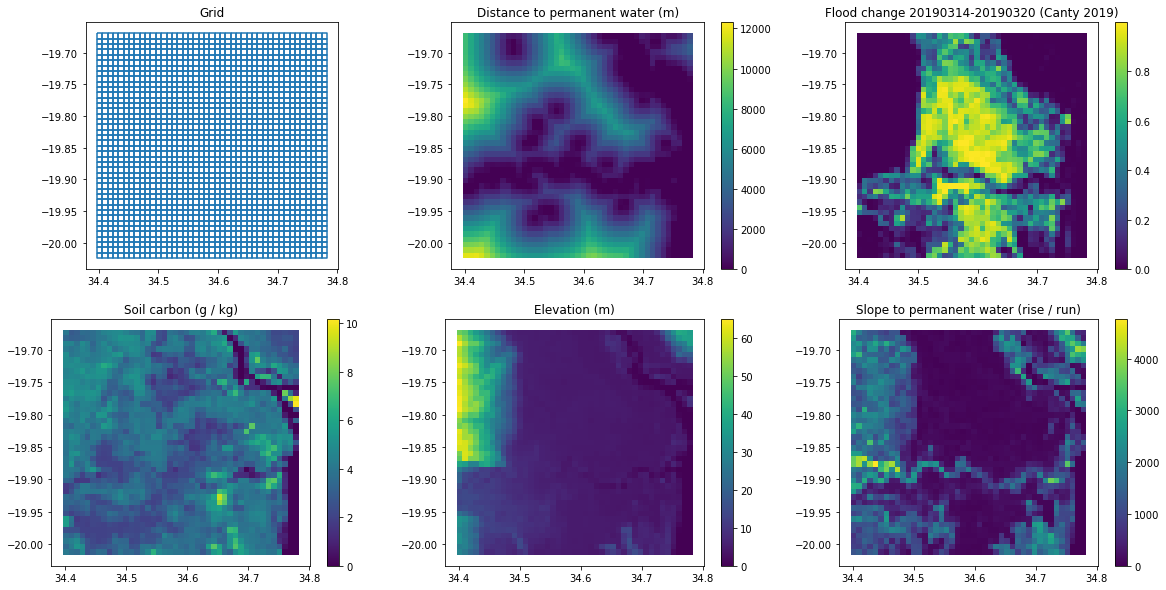

In [177]:
feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp"))
feature_list = [*feature_gdf.columns]
feature_list.remove("floodfrac")
feature_list.remove("geometry")

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

feature_gdf.boundary.plot(ax=ax[0, 0])
feature_gdf.plot(column="dist_pw", ax=ax[0, 1], legend=True)
feature_gdf.plot(column="floodfrac", ax=ax[0, 2], legend=True)

feature_gdf.plot(column="soilcarbon", ax=ax[1, 0], legend=True)
feature_gdf.plot(column="elevation", ax=ax[1, 1], legend=True)
feature_gdf.plot(column="slope", ax=ax[1, 2], legend=True)

ax[0, 0].set_title("Grid");
ax[0, 1].set_title("Distance to permanent water (m)");
ax[0, 2].set_title("Flood change 20190314-20190320 (Canty 2019)")
ax[1, 0].set_title("Soil carbon (g / kg)");
ax[1, 1].set_title("Elevation (m)");
ax[1, 2].set_title("Slope to permanent water (rise / run)");

In [92]:
# train test split
feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp"))
feature_gdf, geometry = feature_gdf.drop(columns="geometry"), feature_gdf["geometry"]
feature_gdf = feature_gdf.dropna()
features = [*feature_gdf.columns]

X, y = feature_gdf.drop(columns="floodfrac"), feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# scale input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list).head()

X_train: (1151, 12)
X_test: (288, 12)
y_train: (1151,)
y_test: (288,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,jrc_permwa,precipitat,dist_pw,slope_pw
0,0.529167,0.169401,0.496268,0.098248,0.123389,0.0,0.719406,0.531263,0.000000,0.962469,0.225685,0.008133
1,0.009452,0.621109,0.523324,0.007510,0.320556,0.0,0.806131,0.619914,0.005841,0.363297,0.143125,0.001173
2,0.007647,0.480657,0.527559,0.004802,0.714479,0.0,0.889491,0.858635,0.000000,0.382363,0.344573,0.000288
3,0.019170,0.724565,0.525459,0.013662,0.159289,0.0,0.902231,0.878794,0.101468,0.382363,0.011621,0.020251
4,0.022806,0.440599,0.534028,0.017044,0.178345,0.0,0.875222,0.810143,0.000000,0.363297,0.674342,0.000067


## MLP parameters
Starting with [this tutorial](https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing).
#### Input
* **shape:** shape tuple, not including batch size, e.g. `shape=(12,)` means the input will be batches of 12-dimensional vectors. Elements can have value `None` which represent dimensions where shape isn't known.

#### Dense
* **units:** dimensionality of the output space
* **output:** n-d tensor with shape (batch_size, ..., units). E.g., for a 2D input with shape (batch_size, input_dim), the output would have shape (batch_size, units).

In [93]:
from tensorflow.keras.optimizers import RMSprop

mlp = Sequential(name='FloodFraction_MLP')

mlp.add(Input(shape=(X_train.shape[1],)))  # (#features,)
mlp.add(Dense(64, activation="relu", name="Layer1"))               # (batch_size, input_dim) -> (batch_size, 64)
mlp.add(Dense(64, activation="relu", name="Layer2"))               # (batch_size, input_dim) -> (batch_size, 64)
mlp.add(Dense(1,  activation="relu", name="RegressionLayer"))      # (batch_size, input_dim) -> (batch_size, 1) [regression]
optimizer = tf.keras.optimizers.RMSprop(0.001)
mlp.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

mlp.summary()

Model: "FloodFraction_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 64)                832       
                                                                 
 Layer2 (Dense)              (None, 64)                4160      
                                                                 
 Layer3 (Dense)              (None, 1)                 65        
                                                                 
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 500

history = mlp.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0)

So the average error in the validation set looks to be around 0.1387which is quite significant.


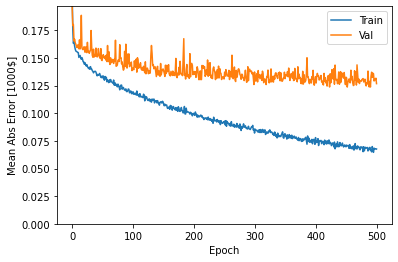

In [111]:
import numpy as np

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val')
    plt.legend()
    plt.ylim([0,max(history.history['val_mae'])])

plot_history(history)

print(f"So the average error in the validation set looks to be around {np.round(np.mean(history.history['val_mae']), 4)}"
      f" which is quite significant.")

In [120]:
[loss, mae] = mlp.evaluate(X_test, y_test, verbose=0)
print("Testing set mean absolute error: {:4.2f}".format(mae))

Testing set mean absolute error: 0.14


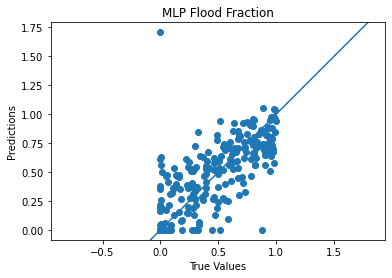

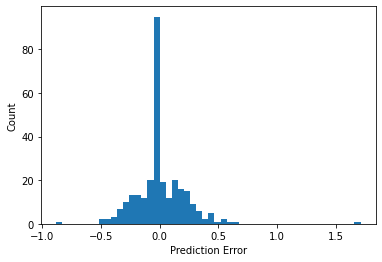

In [151]:
test_predictions = mlp.predict(X_test).flatten()

def plot_prediction(test_labels, test_predictions, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    

plot_prediction(y_test, test_predictions, title="MLP Flood Fraction")

### Conv1D Network
Requires input in the form `[batch_size, time_steps, input_dimension]` but currently data is in the form `[batch_size, features]`. So we pretty much convert the features into timesteps.

In [131]:
sample_size = X_train.shape[0]    # number of samples in train set
time_steps  = X_train.shape[1]    # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("After reshape train data set shape:\n", X_train_reshaped.shape)
print("Single sample shape:\n", X_train_reshaped[0].shape)
print("An example sample:\n", X_train_reshaped[0])

After reshape train data set shape:
 (1151, 12, 1)
Single sample shape:
 (12, 1)
An example sample:
 [[0.52916669]
 [0.16940101]
 [0.49626775]
 [0.09824807]
 [0.123389  ]
 [0.        ]
 [0.71940632]
 [0.53126309]
 [0.        ]
 [0.96246868]
 [0.22568489]
 [0.00813278]]


And so [batch_size, time_steps, input_dimension] -> [1151, 12, 1]. That is, each sample has 12 time steps with 1 input dimension. You can also think as each sample has 12 rows 1 column!

In [134]:
from keras import Sequential
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D

In [139]:
n_timesteps = X_train_reshaped.shape[1]  # 12
n_features  = X_train_reshaped.shape[2]  # 1 

# build model
conv1D = Sequential(name="FloodFraction_Conv1D")
conv1D.add(Input(shape=(n_timesteps,n_features)))

# add three convolutional layers with (64, 32, 16) filters
conv1D.add(Conv1D(filters=64, kernel_size=6, activation='relu', name="Conv1D_1"))
conv1D.add(Dropout(0.5))
conv1D.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
conv1D.add(Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))

# max-pooling layer
conv1D.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))

conv1D.add(Flatten())

# add some dense layers
conv1D.add(Dense(32, activation='relu', name="Dense_1"))
conv1D.add(Dense(n_features, name="Dense_2"))

optimizer = RMSprop(0.001)

conv1D.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
conv1D.summary()

Model: "FloodFraction_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 7, 64)             448       
                                                                 
 dropout_2 (Dropout)         (None, 7, 64)             0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 5, 32)             6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 4, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 2, 16)            0         
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 Dense_1 (Dense)             (None, 32)       

In [141]:
# Store training stats
history = conv1D.fit(X_train_reshaped, y_train, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/500
29/29 [==============================] - 1s 7ms/step - loss: 0.1207 - mae: 0.3005 - val_loss: 0.0896 - val_mae: 0.2672
Epoch 2/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0875 - mae: 0.2558 - val_loss: 0.0618 - val_mae: 0.2071
Epoch 3/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0694 - mae: 0.2174 - val_loss: 0.0554 - val_mae: 0.1935
Epoch 4/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0651 - mae: 0.2054 - val_loss: 0.0557 - val_mae: 0.1875
Epoch 5/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0623 - mae: 0.1991 - val_loss: 0.0534 - val_mae: 0.1840
Epoch 6/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0565 - mae: 0.1866 - val_loss: 0.0508 - val_mae: 0.1739
Epoch 7/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0558 - mae: 0.1843 - val_loss: 0.0499 - val_mae: 0.1719
Epoch 8/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0533 - m

29/29 [==============================] - 0s 2ms/step - loss: 0.0418 - mae: 0.1525 - val_loss: 0.0429 - val_mae: 0.1544
Epoch 64/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0413 - mae: 0.1513 - val_loss: 0.0440 - val_mae: 0.1589
Epoch 65/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0434 - mae: 0.1549 - val_loss: 0.0427 - val_mae: 0.1525
Epoch 66/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0427 - mae: 0.1543 - val_loss: 0.0462 - val_mae: 0.1562
Epoch 67/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0421 - mae: 0.1516 - val_loss: 0.0423 - val_mae: 0.1539
Epoch 68/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0403 - mae: 0.1498 - val_loss: 0.0421 - val_mae: 0.1529
Epoch 69/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0403 - mae: 0.1482 - val_loss: 0.0426 - val_mae: 0.1485
Epoch 70/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0407 - mae: 0

Epoch 125/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0376 - mae: 0.1407 - val_loss: 0.0407 - val_mae: 0.1465
Epoch 126/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0369 - mae: 0.1390 - val_loss: 0.0394 - val_mae: 0.1430
Epoch 127/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0367 - mae: 0.1390 - val_loss: 0.0434 - val_mae: 0.1611
Epoch 128/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0382 - mae: 0.1429 - val_loss: 0.0408 - val_mae: 0.1498
Epoch 129/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0365 - mae: 0.1383 - val_loss: 0.0415 - val_mae: 0.1538
Epoch 130/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0364 - mae: 0.1383 - val_loss: 0.0394 - val_mae: 0.1454
Epoch 131/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0364 - mae: 0.1387 - val_loss: 0.0434 - val_mae: 0.1594
Epoch 132/500
29/29 [==============================] - 0s 2ms/step - 

29/29 [==============================] - 0s 2ms/step - loss: 0.0343 - mae: 0.1342 - val_loss: 0.0441 - val_mae: 0.1563
Epoch 187/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0352 - mae: 0.1353 - val_loss: 0.0399 - val_mae: 0.1462
Epoch 188/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0338 - mae: 0.1302 - val_loss: 0.0396 - val_mae: 0.1438
Epoch 189/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0346 - mae: 0.1350 - val_loss: 0.0391 - val_mae: 0.1425
Epoch 190/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0338 - mae: 0.1321 - val_loss: 0.0418 - val_mae: 0.1476
Epoch 191/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0356 - mae: 0.1348 - val_loss: 0.0409 - val_mae: 0.1491
Epoch 192/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0337 - mae: 0.1334 - val_loss: 0.0405 - val_mae: 0.1430
Epoch 193/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0352 -

Epoch 248/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0309 - mae: 0.1238 - val_loss: 0.0393 - val_mae: 0.1431
Epoch 249/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0316 - mae: 0.1273 - val_loss: 0.0434 - val_mae: 0.1472
Epoch 250/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0331 - mae: 0.1285 - val_loss: 0.0383 - val_mae: 0.1421
Epoch 251/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0324 - mae: 0.1275 - val_loss: 0.0385 - val_mae: 0.1398
Epoch 252/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0312 - mae: 0.1246 - val_loss: 0.0400 - val_mae: 0.1515
Epoch 253/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0320 - mae: 0.1270 - val_loss: 0.0388 - val_mae: 0.1409
Epoch 254/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0329 - mae: 0.1293 - val_loss: 0.0383 - val_mae: 0.1355
Epoch 255/500
29/29 [==============================] - 0s 3ms/step - 

29/29 [==============================] - 0s 2ms/step - loss: 0.0290 - mae: 0.1197 - val_loss: 0.0401 - val_mae: 0.1440
Epoch 310/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0305 - mae: 0.1247 - val_loss: 0.0388 - val_mae: 0.1363
Epoch 311/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0292 - mae: 0.1190 - val_loss: 0.0402 - val_mae: 0.1394
Epoch 312/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0298 - mae: 0.1213 - val_loss: 0.0408 - val_mae: 0.1395
Epoch 313/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0297 - mae: 0.1221 - val_loss: 0.0408 - val_mae: 0.1377
Epoch 314/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0305 - mae: 0.1226 - val_loss: 0.0404 - val_mae: 0.1411
Epoch 315/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0290 - mae: 0.1199 - val_loss: 0.0405 - val_mae: 0.1396
Epoch 316/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0303 -

Epoch 371/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0272 - mae: 0.1143 - val_loss: 0.0462 - val_mae: 0.1464
Epoch 372/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0287 - mae: 0.1186 - val_loss: 0.0404 - val_mae: 0.1379
Epoch 373/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0271 - mae: 0.1161 - val_loss: 0.0403 - val_mae: 0.1365
Epoch 374/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0294 - mae: 0.1198 - val_loss: 0.0385 - val_mae: 0.1342
Epoch 375/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0271 - mae: 0.1184 - val_loss: 0.0417 - val_mae: 0.1391
Epoch 376/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0301 - mae: 0.1224 - val_loss: 0.0392 - val_mae: 0.1332
Epoch 377/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0292 - mae: 0.1209 - val_loss: 0.0415 - val_mae: 0.1396
Epoch 378/500
29/29 [==============================] - 0s 2ms/step - 

29/29 [==============================] - 0s 2ms/step - loss: 0.0262 - mae: 0.1141 - val_loss: 0.0411 - val_mae: 0.1384
Epoch 433/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0269 - mae: 0.1150 - val_loss: 0.0393 - val_mae: 0.1426
Epoch 434/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0275 - mae: 0.1163 - val_loss: 0.0401 - val_mae: 0.1364
Epoch 435/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0265 - mae: 0.1137 - val_loss: 0.0384 - val_mae: 0.1370
Epoch 436/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0270 - mae: 0.1140 - val_loss: 0.0375 - val_mae: 0.1305
Epoch 437/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0279 - mae: 0.1187 - val_loss: 0.0414 - val_mae: 0.1397
Epoch 438/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0260 - mae: 0.1129 - val_loss: 0.0403 - val_mae: 0.1391
Epoch 439/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0277 -

Epoch 494/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0258 - mae: 0.1138 - val_loss: 0.0387 - val_mae: 0.1334
Epoch 495/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0238 - mae: 0.1097 - val_loss: 0.0399 - val_mae: 0.1432
Epoch 496/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0281 - mae: 0.1193 - val_loss: 0.0379 - val_mae: 0.1306
Epoch 497/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0248 - mae: 0.1104 - val_loss: 0.0378 - val_mae: 0.1298
Epoch 498/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0253 - mae: 0.1113 - val_loss: 0.0373 - val_mae: 0.1404
Epoch 499/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0271 - mae: 0.1165 - val_loss: 0.0391 - val_mae: 0.1348
Epoch 500/500
29/29 [==============================] - 0s 2ms/step - loss: 0.0261 - mae: 0.1130 - val_loss: 0.0408 - val_mae: 0.1389


So the average error in the validation set looks to be around 0.1457


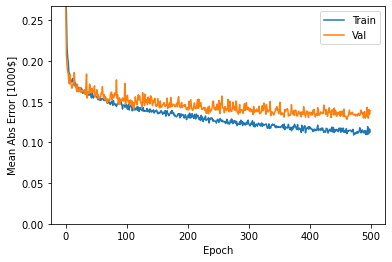

In [145]:
plot_history(history)

print(f"So the average error in the validation set looks to be around {np.round(np.mean(history.history['val_mae']), 4)}")

In [146]:
[loss, mae] = conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set mean absolute error: {:4.2f}".format(mae))

Testing set mean absollute error: 0.15


In [148]:
print(features)

['elevation', 'aspect', 'curvature', 'slope', 'soilcarbon', 'mangroves', 'ndvi_mfmas', 'evi_mfmask', 'jrc_permwa', 'precipitat', 'floodfrac', 'dist_pw', 'slope_pw']


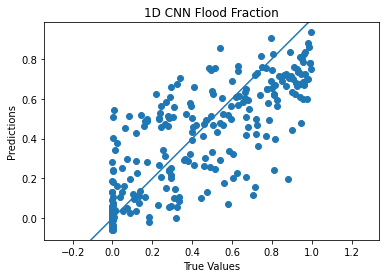

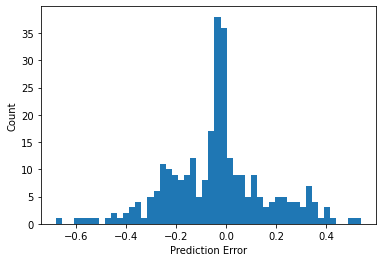

In [152]:
test_predictions = conv1D.predict(X_test_reshaped).flatten()
plot_prediction(y_test, test_predictions, title="1D CNN Flood Fraction")

### Code dataframe into matrix representing spatial grid

    # get dimensions, TODO: make this more elegant
    from shapely.geometry import box
    feature_gdf_pm = feature_gdf.to_crs("EPSG:3857")
    bbounds = feature_gdf_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / 1000, 0))
    ncols = int(np.round(width  / 1000, 0))
    print(f"nrows:{nrows}, ncols: {ncols}")

    def reshape_df(df, nrows, ncols):
        feature_mat = np.empty(shape=(len(feature_list), nrows, ncols), dtype="object")
        for i, feature in enumerate(feature_list):
            feature_arr = df[feature].values.reshape(42, 43, order="F")
            feature_mat[i, :, :] = feature_arr

            return feature_mat

    reshape_df(X_train, nrows, ncols)